# 最大シーケンス長のデータを調べる

In [3]:
import os
import glob
import json
import sys


"""
~~~ Result ~~~

Files scanned: 10039
Max utterance sequence length: 100
Number of files with max length: 1

== data/IEMOCAP/raw-texts/test/Ses05M_impro08_F000.json
Utterance count: 1
Total words (this file): 100
Longest single utterance (words): 100
Utterances:
0001: Hi, I need- I need some help.  I've been transferred to, like, eight different departments and I've told my problem to every single department, and then they just send me to another one and say they are going to send all my information so I won't have to repeat it, and then that person doesn't know what's going on.  And I've restated my story about eight different times and I just want somebody to help me get my connection back, because this happens every two weeks.  And I want to know what to do to stop it from happening again.
"""


BASE = "data/IEMOCAP/raw-texts"

def extract_utterances(obj):
    # returns list of utterance strings found in obj
    utterances = []
    if isinstance(obj, list):
        for item in obj:
            if isinstance(item, dict) and "Utterance" in item:
                utterances.append(item.get("Utterance"))
    elif isinstance(obj, dict):
        # check top-level keys whose values are lists of utterance dicts
        for v in obj.values():
            if isinstance(v, list):
                for item in v:
                    if isinstance(item, dict) and "Utterance" in item:
                        utterances.append(item.get("Utterance"))
        # also check if the dict itself is a single utterance
        if "Utterance" in obj and isinstance(obj["Utterance"], str):
            utterances.insert(0, obj["Utterance"])
    return [u for u in utterances if u is not None]


def main():
    files = glob.glob(os.path.join(BASE, "**", "*.json"), recursive=True)
    if not files:
        print("No JSON files found under", BASE)
        sys.exit(0)

    stats = []
    for p in files:
        try:
            with open(p, "r", encoding="utf-8") as f:
                obj = json.load(f)
        except Exception as e:
            print("skip (load error):", p, "-", e)
            continue
        utterances = extract_utterances(obj)
        # count utterances and words
        total_words = sum(len(u.split()) for u in utterances)
        max_words_in_utt = max((len(u.split()) for u in utterances), default=0)
        stats.append((p, len(utterances), total_words, max_words_in_utt, utterances))

    if not stats:
        print("No readable JSON files with utterances.")
        sys.exit(0)

    # choose metric: total words across file (index 2). Change to index 1 if you want utterance count.
    max_total_words = max(s[2] for s in stats)
    max_files = [s for s in stats if s[2] == max_total_words]

    print("Files scanned:", len(stats))
    print("Max utterance sequence length:", max_total_words)
    print("Number of files with max length:", len(max_files))
    print()

    # If multiple files have the same max length, pick the first one deterministically
    max_files.sort(key=lambda x: x[0])
    p, utt_count, total_words, max_words_in_utt, utts = max_files[0]
    print("==", p)
    print(f"Utterance count: {utt_count}")
    print(f"Total words (this file): {total_words}")
    print(f"Longest single utterance (words): {max_words_in_utt}")
    print("Utterances:")
    for i, u in enumerate(utts, 1):
        print(f"{i:04d}: {u}")
    print()

if __name__ == "__main__":
    main()

Files scanned: 10039
Max utterance sequence length: 100
Number of files with max length: 1

== data/IEMOCAP/raw-texts/test/Ses05M_impro08_F000.json
Utterance count: 1
Total words (this file): 100
Longest single utterance (words): 100
Utterances:
0001: Hi, I need- I need some help.  I've been transferred to, like, eight different departments and I've told my problem to every single department, and then they just send me to another one and say they are going to send all my information so I won't have to repeat it, and then that person doesn't know what's going on.  And I've restated my story about eight different times and I just want somebody to help me get my connection back, because this happens every two weeks.  And I want to know what to do to stop it from happening again.



# ignoreの数を調べる

In [32]:
import json 
import pathlib


"""
~~~Emotionがundecided の Results~~~
test: undecided=520, total_files=2170, parse_errors=0
train: undecided=1587, total_files=6468, parse_errors=0
val: undecided=400, total_files=1401, parse_errors=0

~~~Emotionが6種類のうちどれでもない の Results~~~
test: ignore=548, total_files=2170, parse_errors=0
train: ignore=1690, total_files=6468, parse_errors=0
val: ignore=421, total_files=1401, parse_errors=0
"""


root = pathlib.Path("data/IEMOCAP/raw-texts")
emotion_lst = ["happiness", "sadness", "neutral", "anger", "excited", "frustration"]


for sub in ("test","train","val"):
    p = root / sub
    total = 0
    ignore = 0
    parse_err = 0
    for f in p.glob("*.json"):
        total += 1
        try:
            obj = json.loads(f.read_text(encoding="utf-8"))
            if str(obj.get("Emotion","")).lower() not in emotion_lst:
                ignore += 1
        except Exception:
            parse_err += 1
    print(f"{sub}: ignore={ignore}, total_files={total}, parse_errors={parse_err}")

test: ignore=548, total_files=2170, parse_errors=0
train: ignore=1690, total_files=6468, parse_errors=0
val: ignore=421, total_files=1401, parse_errors=0


# 各ラベル「間」を可視化する

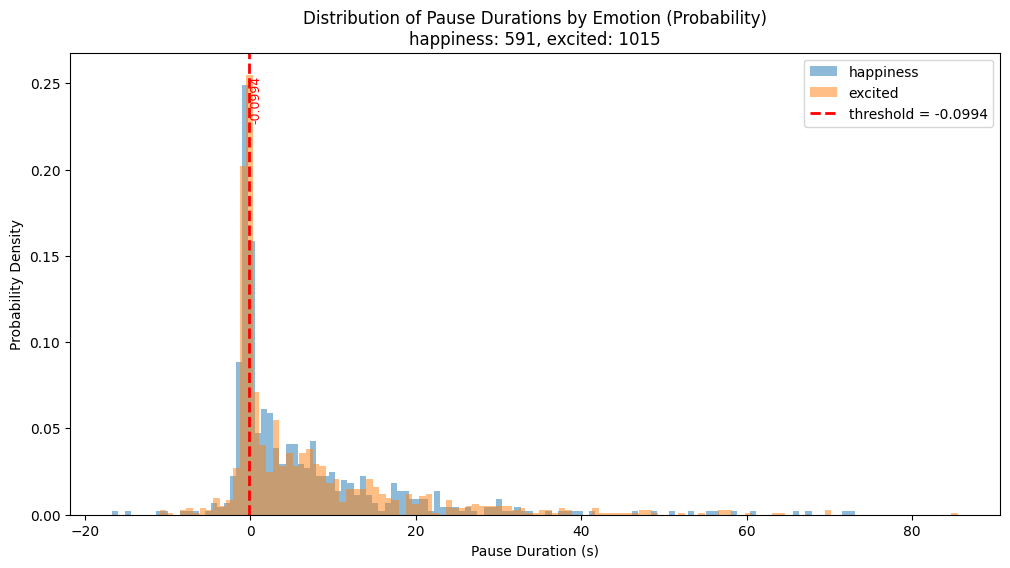

In [59]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "./data/IEMOCAP/"
ordered_json_file = os.path.join(base_dir, "utterance-ordered.json")
raw_folder = os.path.join(base_dir, "raw-texts")


if not os.path.isfile(ordered_json_file):
    raise FileNotFoundError(f"Ordered JSON file not found: {ordered_json_file}")

with open(ordered_json_file, "r", encoding="utf-8") as f:
    ordered_json_content = json.load(f)

# real_avg = 0.2
# avg = -0.4630329288025866
# avg_gap = real_avg - avg

exclude = {"disgust", "other", "fear", "surprise", "undecided"}
add_exclude = {"happiness", "excited"}
emotion_between = {}

time_threshold = -0.0994

for split in ["train", "val", "test"]:
    for _, filenames in ordered_json_content[split].items():
        prev_end = 0.0
        for i, filename in enumerate(filenames):
            path = os.path.join(raw_folder, split, filename if filename.endswith(".json") else filename + ".json")
            if not os.path.isfile(path):
                continue
            with open(path, "r", encoding="utf-8") as jf:
                data = json.load(jf)
                utterance = data["Utterance"]
                utterance_lst = utterance.split(" ")

            # if (data["SessionID"] == "Ses03") and (data["Speaker"] == "Female"):
                if (i == 0):
                    prev_end = data["EndTime"]
                    continue
                emotion = data["Emotion"]
                if ((emotion in exclude)  or  (emotion not in add_exclude)):
                # if (emotion in exclude):
                    prev_end = data["EndTime"]
                    continue
                between = data["StartTime"] - prev_end
                # between += avg_gap

                if (emotion not in emotion_between):
                    emotion_between[emotion] = []
                emotion_between[emotion].append(between)


# ヒストグラムを表示する
import matplotlib.pyplot as plt

# ヒストグラムのビン数
bins = 120

# 各感情のサンプル数を取得
emotion_counts = {emotion: len(durations) for emotion, durations in emotion_between.items()}

# タイトルに感情ごとのサンプル数を追加
title = "Distribution of Pause Durations by Emotion (Probability)\n" + ", ".join([f"{emotion}: {count}" for emotion, count in emotion_counts.items()])

# ヒストグラムを表示する
plt.figure(figsize=(12, 6))
bin_edges = None  # ビンの境界を保存する変数

# 各感情の割合を計算
emotion_ratios = {}

for emotion, durations in emotion_between.items():
    # ヒストグラムを計算（density=Trueで確率密度に正規化）
    counts, bin_edges = np.histogram(durations, bins=bins, density=True)
    # 確率に変換（各ビンの幅を掛けて積分が1になるようにする）
    bin_width = bin_edges[1] - bin_edges[0]
    probabilities = counts * bin_width  # 各ビンの確率
    emotion_ratios[emotion] = probabilities

    # ヒストグラムをプロット（density=Trueで確率密度として表示）
    plt.hist(durations, bins=bin_edges, alpha=0.5, label=emotion, density=True)

# 赤い線で閾値を表示（凡例用ラベル付き）
plt.axvline(time_threshold, color="red", linestyle="--", linewidth=2, label=f"threshold = {time_threshold:.4f}")

# ラインのラベルをグラフ内に注記（任意）
ymin, ymax = plt.ylim()
plt.text(time_threshold, ymax * 0.95, f"{time_threshold:.4f}", color="red", ha="left", va="top", rotation=90, fontsize=9)

plt.xlabel("Pause Duration (s)")
plt.ylabel("Probability Density")
plt.title(title)
plt.legend()
plt.show()

# 各ラベル「発話スピード」を可視化する

In [45]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "./data/IEMOCAP/"
ordered_json_file = os.path.join(base_dir, "utterance-ordered.json")
raw_folder = os.path.join(base_dir, "raw-texts")


if not os.path.isfile(ordered_json_file):
    raise FileNotFoundError(f"Ordered JSON file not found: {ordered_json_file}")

with open(ordered_json_file, "r", encoding="utf-8") as f:
    ordered_json_content = json.load(f)

exclude = {"disgust", "other", "fear", "surprise", "undecided"}
emotion_speed_dct = {}

for split in ["train", "val", "test"]:
    for _, filenames in ordered_json_content[split].items():
        for i, filename in enumerate(filenames):
            path = os.path.join(raw_folder, split, filename if filename.endswith(".json") else filename + ".json")
            if not os.path.isfile(path):
                continue
            with open(path, "r", encoding="utf-8") as jf:
                data = json.load(jf)
                utterance = data["Utterance"]
                utterance_lst = utterance.split(" ")
                # print(len(utterance_lst), utterance)

            emotion = data["Emotion"]
            if (emotion not in exclude):
                start_time = data["StartTime"]
                end_time = data["EndTime"]
                utterance_time = end_time - start_time
                char_num = 0
                for word in utterance_lst:
                    char_num += len(word)
                # avoid division by zero
                if char_num == 0:
                    continue
                speed = utterance_time / char_num
                if (emotion not in emotion_speed_dct):
                    emotion_speed_dct[emotion] = []
                emotion_speed_dct[emotion].append(speed)


# --- ここから平均と分散を計算して出力 ---
rows = []
for emo, vals in emotion_speed_dct.items():
    arr = np.array(vals, dtype=float)
    rows.append({
        "emotion": emo,
        "count": arr.size,
        "mean": float(arr.mean()) if arr.size > 0 else float("nan"),
        "variance": float(arr.var()) if arr.size > 0 else float("nan"),  # population variance
    })
df_stats = pd.DataFrame(rows).set_index("emotion").sort_values("mean")
print("Per-emotion statistics (count, mean, variance):")
print(df_stats)
# --- 計算ここまで ---


Per-emotion statistics (count, mean, variance):
             count      mean  variance
emotion                               
anger         1103  0.112614  0.004691
excited       1041  0.113960  0.003920
frustration   1849  0.116909  0.007401
neutral       1708  0.130338  0.007841
happiness      595  0.132492  0.007508
sadness       1084  0.163819  0.013198


# 各ラベル+各人ごとの「間」

In [50]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

base_dir = "./data/IEMOCAP/"
ordered_json_file = os.path.join(base_dir, "utterance-ordered.json")
raw_folder = os.path.join(base_dir, "raw-texts")


if not os.path.isfile(ordered_json_file):
    raise FileNotFoundError(f"Ordered JSON file not found: {ordered_json_file}")

with open(ordered_json_file, "r", encoding="utf-8") as f:
    ordered_json_content = json.load(f)

real_avg = 0.2
avg = -0.4630329288025866
avg_gap = real_avg - avg

exclude = {"disgust", "other", "fear", "surprise", "undecided"}
# add_exclude = {"sadness", "frustration"}
emotion_between = {}

for split in ["train", "val", "test"]:
    for _, filenames in ordered_json_content[split].items():
        prev_end = 0.0
        for i, filename in enumerate(filenames):
            path = os.path.join(raw_folder, split, filename if filename.endswith(".json") else filename + ".json")
            if not os.path.isfile(path):
                continue
            with open(path, "r", encoding="utf-8") as jf:
                data = json.load(jf)
                utterance = data["Utterance"]
                utterance_lst = utterance.split(" ")

            if (data["SessionID"] == "Ses03") and (data["Speaker"] == "Female"):
                if (i == 0):
                    prev_end = data["EndTime"]
                    continue
                emotion = data["Emotion"]
                # if ((emotion in exclude)  or  (emotion not in add_exclude)):
                if (emotion in exclude):
                    prev_end = data["EndTime"]
                    continue
                between = data["StartTime"] - prev_end
                between += avg_gap

                if (emotion not in emotion_between):
                    emotion_between[emotion] = []
                emotion_between[emotion].append(between)


# --- ここから平均と分散を計算して出力 ---
rows = []
for emo, vals in emotion_between.items():
    arr = np.array(vals, dtype=float)
    rows.append({
        "emotion": emo,
        "count": arr.size,
        "mean": float(arr.mean()) if arr.size > 0 else float("nan"),
        "variance": float(arr.var()) if arr.size > 0 else float("nan"),  # population variance
    })
df_stats = pd.DataFrame(rows).set_index("emotion").sort_values("mean")
print("Per-emotion statistics (count, mean, variance):")
print(df_stats)
# --- 計算ここまで ---

Per-emotion statistics (count, mean, variance):
             count       mean     variance
emotion                                   
excited         48  11.194450    67.008641
happiness       79  28.763344   861.438299
anger           90  34.882707  1950.966710
frustration    197  44.955558  2369.971603
neutral        126  49.312820  3053.566443
sadness        171  62.017334  3722.055502
